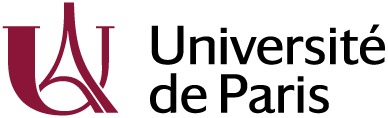
## M2 VMI - TP AD: Object detection using CNNs - Facemasks

Sylvain Lobry

Pre-requisite: having a google account (sorry about that...)

In this lab we are going to train a model to detect if people are (correctly) wearing face masks. As data, we will use [one of the datasets available on Kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection).

## 1) Loading the data
You can get the data [from kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection) directly, or through my [Google Drive](https://drive.google.com/drive/folders/1oxP0ept0pmOgjl1BbYaUj9Cf_X7FnI2A?usp=sharing). Then, copy it to your drive.

Now, you need to mount your drive in this VM. This is done by executing the following two lines. You will need to authorize google collab to access to your drive (it will ask you to open a link and give you a confirmation code that you will have to copy on the text field bellow).

In [1]:
data_folder = 'C:/Users/shets/Desktop/archive' #Change this path!!
root_folder = 'C:/Users/shets/Desktop/'#Change this path!!

## 2) Understanding the data format
In the data folder, you have 2 sub-folders:


1.   images
2.   annotations

The images are in the png format, and the annotations are in the xml format.

**Question 1:** Open an xml file, and try to understand the information it contains and describe it. From this xml, can you guess what bounding box format is used in this dataset?

**<p style="color: green">Answer 1:</p>** 
```
Taking the first one as an example we can see that essentially we have two informations.
First: we have some information about the image, such as height, width and depth.
Second: the objects where each object represents a ROI and a label associated with it in the <name> tag. 
        We also have some other infos such as pose and difficulty, but the most important one for us is the bounding box
        which is located in the <bndbox> tag that contains 4 sub tags, which are the four coords of the rectangle (ROI).
        xmin, ymin, xmax and ymax.

The format of the bounding box used in this dataset is: (x,y) of top left and bottom right corners.
    
```

Let's parse one XML:

In [2]:
import os
import xml.etree.ElementTree as ET

def get_objects(xml_file):
  annotation = ET.parse(xml_file)
  root = annotation.getroot()

  objects = []
  for obj in root.findall('object'):
    new_object = {'name': obj.find('name').text}
    bbox_tree = obj.find('bndbox')
    coords = ['xmin', 'ymin', 'xmax', 'ymax']
    new_object['bbox'] = [int(bbox_tree.find(c).text) for c in coords]
    objects.append(new_object)
  return objects

and show the bounding boxes on one image:

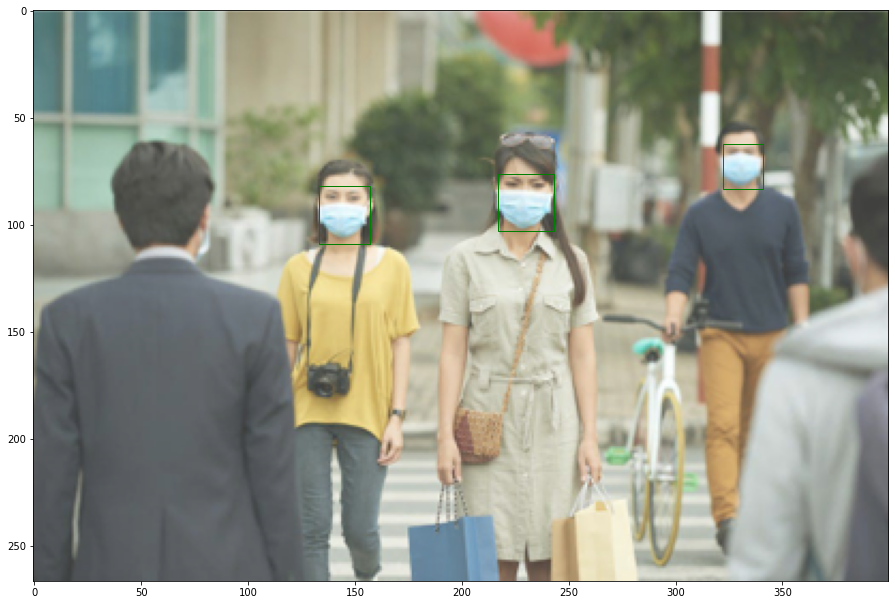

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Color of the bounding boxes (depending on the class)
classes_color = {'with_mask':'g', 'without_mask':'r', 'mask_weared_incorrect':'tab:orange'}
classes_index = {'with_mask':1, 'without_mask':2, 'mask_weared_incorrect':3} #Careful!! 0 is for background!!

def show_bboxes(image, objects):
  fig,ax = plt.subplots(1)
  fig.set_size_inches(18.5, 10.5)
  ax.imshow(image)

  for annotation in objects:
    xmin, ymin, xmax, ymax = annotation['bbox']
    rect = patches.Rectangle((xmin,ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor=classes_color[annotation['name']], facecolor='none')
    ax.add_patch(rect)
  plt.show()

index = 519
objects = get_objects(os.path.join(data_folder, 'annotations', 'maksssksksss' + str(index) + '.xml'))
image = plt.imread(os.path.join(data_folder, 'images', 'maksssksksss' + str(index) + '.png'))
show_bboxes(image, objects)

**Question 2:** We are going to learn from this data. By looking at it, can you find possible biases in it?

**<p style="color: green">Answer 2:</p>** 
```
In the dataset, we can see varying types of masks, different colors and textures which is good, we also have different backgrounds in the images, different environements, crowded places and selfies, different angles of photoshoots (side, front, down), we also have kids, young and elderly people.

What we can see is that all of the people presented in the dataset are either asians or white, which makes me think that it lacks other ethnecities and our model may be trained and biased by the ethnicity.

My point is, suppose that we have a dataset that consists of only white people and only black masks, the question is what happens if we showed the model a black man ? would it be biased by the color of the mask ?

Also, all the pictures were taken in daylight, very good lighting conditions, which also makes us wonder what would happen when given a poor light conditions or a picture taken at night ?
    
Another thing about masks, is that most people here are either wearing the mask correctly or don't wear it at all, very few who wears it incorrectly.
```

## 3) Creating the dataset class

Now, we need to create a class derived from pytorch's Dataset class able to understand or data format. Since the datasert is not too big, we can load it entirely in RAM.

In [4]:
from torch.utils.data import Dataset
import torchvision.transforms as T
from tqdm.notebook import tqdm
from PIL import Image

class FaceMaskDataset(Dataset):
  def __init__(self, img_folder, annotation_folder, indexes, conversion=T.ToTensor()):
    self.conversion = conversion
    
    self.dataset = []
    for index in tqdm(indexes):
      sample = {}
      sample['image'] = Image.open(os.path.join(img_folder, 'maksssksksss' + str(index) + '.png')).convert('RGB')
      sample['objects'] = get_objects(os.path.join(annotation_folder, 'maksssksksss' + str(index) + '.xml'))  
      sample['id'] = index
      self.dataset.append(sample)
    
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    target = {'boxes': [], 'labels': []}
    for obj in self.dataset[idx]['objects']:
      target["boxes"].append(obj['bbox'])
      target['labels'].append(classes_index[obj['name']])
      
    target["boxes"] = torch.as_tensor(target["boxes"], dtype=torch.float32)
    target["labels"] = torch.as_tensor(target['labels'], dtype=torch.int64)
    target["image_id"] = torch.tensor([self.dataset[idx]['id']])

    img = self.dataset[idx]['image']
    if self.conversion is not None:
      img = self.conversion(img)
    return img, target

And we can create the datasets.

**Question 3:** What is the total number of samples that we have? Does that seem sufficient to train a model? What strategy could we use for training? 

**<p style="color: green">Answer 3:</p>** 
```
Total number of images we have is 853.
It is not a big number and we doubt that it will be sufficient, so we may do some data augmentation to show more examples to our model.
Though the data augmentation should obviously take into account the adjustement of the bounding boxes in the augmented version.

    
```

In [5]:
import random
import torch

train_split_percentage = 0.7
val_split_percentage = 0.15
test_split_percentage = 0.15
size_of_the_dataset = 853

indexes = list(range(size_of_the_dataset))
random.shuffle(indexes)

train_indexes = indexes[:int(train_split_percentage*len(indexes))]
val_indexes = indexes[int(train_split_percentage*len(indexes)):int((train_split_percentage + val_split_percentage)*len(indexes))]
test_indexes = indexes[int((train_split_percentage + val_split_percentage)*len(indexes)):]

print(f"Effective train split = {len(train_indexes)/len(indexes)*100}%")
print(f"Effective val split = {len(val_indexes)/len(indexes)*100}%")
print(f"Effective test split = {len(test_indexes)/len(indexes)*100}%", flush=True)

# From https://github.com/pytorch/vision/blob/ce342580f3ae3f937fa5389c48b82a827b4804df/references/detection/utils.py#L235
def collate_fn(batch):
    return tuple(zip(*batch))



def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    #TODO: potentially add data augmentation
    return T.Compose(transforms)

batch_size = 1
print("Loading training set")
train_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), train_indexes, conversion=get_transform(True))
print("Loading validation set")
val_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), val_indexes, conversion=get_transform(False))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True)

Effective train split = 69.98827667057445%
Effective val split = 15.005861664712777%
Effective test split = 15.005861664712777%
Loading training set


  0%|          | 0/597 [00:00<?, ?it/s]

Loading validation set


  0%|          | 0/128 [00:00<?, ?it/s]

One thing which is always important is to check the data. At the sample size, we have already seen how to check that we understood the data format, and checked a few samples for corectness. At a larger scale, it is often a good idea to check the labels' distribution.

**Question 4:** Propose and implement a methodology to check the labels' distribution. Discuss your findings.

**<p style="color: green">Answer 3:</p>** 
```
While letting the model train on the notebook, I opened another ipython session and wrote this simple function to have an idea about the distribution of the labels we got in the dataset. We can see the the majority of the people presented in the images we have are with a mask, 3232 vs 717 who doesn't have any mask at all, so we have a very imbalanced dataset.


In [27]: def f():
    ...:     files = list(os.walk(data_folder / 'annotations'))[0][2]
    ...:     possible_values = ['without_mask', 'with_mask', 'without_mask', 'mask_weared_incorrect']
    ...:     d = dict(zip(possible_values, [0,0,0,0]))
    ...:     for file in files:
    ...:         objs = get_objects(data_folder / 'annotations' / file)
    ...:         for obj in objs:
    ...:             d[obj['name']] += 1
    ...:     return d
    ...:

In [28]: f()
Out[28]: {'without_mask': 717, 'with_mask': 3232, 'mask_weared_incorrect': 123}
    
    
With a simple bar plot, we can see the huge imbalance we have.
```
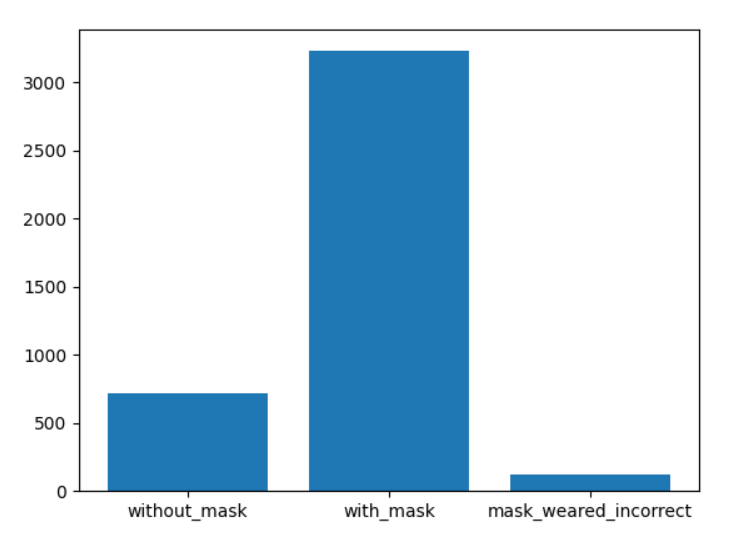

```
This isn't so good, a good thing to do is to try to upsample the images in which there are people with no mask or wear a mask incorrectly, but since we have multiple persons in the same image, it makes the task very hard to realise.
If we had one person per image, we could've tried to upsample both or do some data augmentation only on the images with no mask to balance it a little bit.
```

## 4) Defining the model

For this project, we propose to take a pre-trained Faster R-CNN.

Faster R-CNN is an extension of R-CNN seen during the lecture. Conceptually, both methods are very similar. The main improvements of Faster R-CNN is to share convolutional features between the region proposal part and the actual object detection part. To know more, you can read [the original article](https://arxiv.org/pdf/1506.01497.pdf).

This network has been pre-trained on [MS-COCO](https://cocodataset.org/#home), which is a classical large-scale object detection dataset.


In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#load Faster R-CNN pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#Change the classifier head with a new one:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 4 #(3 + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## 5) Training

Now that we have both the architecture and the data, we can train our model.

You should enable GPU in your collab at this point. To do so go to runtime -> Change runtime type -> Hardware accelerator and select "GPU";

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
!nvidia-smi

model = model.to(device)

Using device: cuda
Sun Oct 17 18:40:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.81       Driver Version: 466.81       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P0    24W /  N/A |    121MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                     

We can now define the training loop.

**Question 5:** How did you choose your hyper-parameters?

**<p style="color: green">Answer 3:</p>** 
```
the hyper-parameters were cherry picked by hand, we tried different values and we adjusted relying on the results we had.
```

In [8]:
model.load_state_dict(torch.load("C:/Users/shets/Downloads/model_epoch4.pt"))

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

## 6) Evaluate the model
First, we need to load the test set:

**TODO** Now you need to re-use what you have seen before to do the evaluation (both with losses and classical metrics). You need to discuss it.

Good luck!

In [196]:
import torchvision.ops.boxes as bops
from torchvision.ops import nms

In [121]:
print("Loading test set")
test_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), test_indexes, conversion=get_transform(False))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

Loading test set


  0%|          | 0/128 [00:00<?, ?it/s]

### Non Maximum suppression

In [213]:
def non_maximum_suppression(pred, threshold):
    to_keep_indices = nms(pred[0]['boxes'], pred[0]['scores'], 0.001)
    pred[0]['boxes'] = pred[0]['boxes'][to_keep_indices]
    pred[0]['scores'] = pred[0]['scores'][to_keep_indices]
    pred[0]['labels'] = pred[0]['labels'][to_keep_indices]
    
    return pred

### Calculating the mean IoU over all the test set over all the bounding boxes

In [274]:
model.eval()
THRESHOLD = 0.5 # for NMS

s = 0
i = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = list(image.to(device) for image in images)
        labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
        gt_boxs = labels[0]['boxes']
        pred = model(images)
        pred = non_maximum_suppression(pred, THRESHOLD)
            
        i += 1
#         if i < 10:
#             continue
#         else:
#             print(pred)
#             print(labels)
#             break
        
        
        
        s += bops.box_iou(pred[0]['boxes'][:len(gt_boxs)], gt_boxs).max(1)[0].mean().item()
        
s /= i
print('Mean IoU is ', s)

  0%|          | 0/128 [00:00<?, ?it/s]

Mean IoU is  0.8668512357398868


### Rearranging the order and collecting all the predicted and ground truth labels

In [292]:
# Grabbing all predictions and GT labels in one place to have the confusion matrix
all_predicted_labels = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = list(image.to(device) for image in images)
        labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
        gt_boxs = labels[0]['boxes']
        pred = model(images)
        pred = non_maximum_suppression(pred, THRESHOLD)
        '''
        get the predictions boxes and the GT boxes, then adjust the predicted labels ( changing their order )
        based on the maximum overlap between the predicted boxes and the GT boxes
        '''
        all_predicted_labels.extend(pred[0]['labels'][bops.box_iou(labels[0]['boxes'], pred[0]['boxes'].detach()).max(1).indices].cpu().numpy())
        all_labels.extend(labels[0]['labels'].cpu().numpy())

  0%|          | 0/128 [00:00<?, ?it/s]

### Confusion matrix

In [301]:
target_names = ['with_mask', 'without_mask', 'mask_weared_incorrect']
print(classification_report(all_labels, all_predicted_labels, target_names=target_names))

                       precision    recall  f1-score   support

            with_mask       0.95      1.00      0.97       475
         without_mask       0.97      0.93      0.95       179
mask_weared_incorrect       0.00      0.00      0.00        16

             accuracy                           0.96       670
            macro avg       0.64      0.64      0.64       670
         weighted avg       0.93      0.96      0.94       670

